In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.covariance import MinCovDet

##############################################################################
# 1. Data Generation
##############################################################################

def generate_data(n, p, contamination=0.0, shift=10.0, seed=None):
    """
    Generates n x p data from N(0, I), then contaminates a fraction of points
    by adding a shift.
    
    Returns:
    --------
    X        : (n, p) ndarray
    mu_true  : (p,) the true mean (zeros by default)
    Sigma_true: (p,p) identity matrix
    """
    if seed is not None:
        np.random.seed(seed)

    mu_true = np.zeros(p)
    Sigma_true = np.eye(p)

    # Clean data
    X_clean = np.random.multivariate_normal(mean=mu_true, cov=Sigma_true, size=n)

    # Contamination
    n_out = int(contamination * n)
    if n_out > 0:
        outlier_indices = np.random.choice(n, n_out, replace=False)
        # Shifted outliers
        X_outliers = np.random.multivariate_normal(mean=shift * np.ones(p), 
                                                   cov=Sigma_true, 
                                                   size=n_out)
        X_clean[outlier_indices] = X_outliers

    return X_clean, mu_true, Sigma_true

In [3]:

##############################################################################
# 2. Estimators
##############################################################################

def classical_estimator(X):
    """
    Returns sample mean and sample covariance.
    """
    mu_c = np.mean(X, axis=0)
    Sigma_c = np.cov(X, rowvar=False)
    return mu_c, Sigma_c

def compute_errors(mu_est, Sigma_est, mu_true, Sigma_true):
    """
    Return L2 norm error for location, and Frobenius norm error for covariance.
    """
    loc_err = np.linalg.norm(mu_est - mu_true)
    cov_err = np.linalg.norm(Sigma_est - Sigma_true, 'fro')
    return loc_err, cov_err

In [10]:

##############################################################################
# 3. Simulation / Efficiency / Robustness Study
##############################################################################

def run_simulation(p_values=[2,5,10,15],
                   n=200, 
                   contamination_levels=[0.0, 0.05, 0.1, 0.2, 0.25], 
                   n_sims=100):
    """
    For each p in p_values, and for each contamination alpha,
    we generate data, estimate location/cov using classical and MCD,
    record errors in location/cov, then return a DataFrame.
    """
    records = []

    for p in p_values:
        for alpha in contamination_levels:
            for sim in range(n_sims):
                X, mu_true, Sigma_true = generate_data(n, p, 
                                                      contamination=alpha)

                # 1. Classical
                mu_c, Sigma_c = classical_estimator(X)

                # 2. MCD from sklearn (FastMCD by default)
                mcd = MinCovDet(support_fraction=0.5).fit(X)
                mu_mcd = mcd.location_
                Sigma_mcd = mcd.covariance_

                # 3. Optionally, just call the same MCD as 'FastMCD'
                #    In scikit-learn, there's no separate "slow MCD" 
                #    implementation. It's always the fast one under the hood.
                
                # Record errors
                loc_err_c, cov_err_c = compute_errors(mu_c, Sigma_c, mu_true, Sigma_true)
                loc_err_m, cov_err_m = compute_errors(mu_mcd, Sigma_mcd, mu_true, Sigma_true)

                records.append({
                    'dim': p,
                    'contamination': alpha,
                    'sim': sim,
                    'method': 'classical',
                    'loc_err': loc_err_c,
                    'cov_err': cov_err_c
                })
                records.append({
                    'dim': p,
                    'contamination': alpha,
                    'sim': sim,
                    'method': 'mcd',
                    'loc_err': loc_err_m,
                    'cov_err': cov_err_m
                })
                
                # If you had a separate "FastMCD" label, you'd replicate the same:
                # records.append({
                #     'dim': p,
                #     'contamination': alpha,
                #     'sim': sim,
                #     'method': 'fast_mcd',
                #     'loc_err': loc_err_m,
                #     'cov_err': cov_err_m
                # })
                # But realistically it's identical to 'mcd' in sklearn.
                
    df = pd.DataFrame(records)
    return df

In [11]:

##############################################################################
# 4. Efficiency Calculation
##############################################################################

def compute_efficiency(df, method='mcd', reference='classical', alpha=0.0):
    """
    An approximate measure of efficiency:
    1. Filter df to contamination=alpha (uncontaminated scenario).
    2. Compare the variance (or mean square) of method's loc_err 
       with reference's loc_err.
    
    Efficiency = Var(ref) / Var(method)
    (the ratio of the variance of the reference estimator's error 
     to the variance of the method's error).

    For a more formal approach, you'd look at each coordinate 
    of the location separately or 
    do a more thorough asymptotic analysis. 
    """
    df_alpha = df[(df['contamination'] == alpha)]
    
    # group by dimension, then compute variance
    eff_records = []
    for p, sub in df_alpha.groupby('dim'):
        sub_ref = sub[sub['method'] == reference]
        sub_m = sub[sub['method'] == method]
        
        # mean squared error for location:
        ref_var = np.var(sub_ref['loc_err'])
        m_var = np.var(sub_m['loc_err'])
        
        # ratio
        eff = ref_var / m_var if m_var > 1e-12 else np.inf
        
        eff_records.append({
            'dim': p,
            'method': method,
            'reference': reference,
            'alpha': alpha,
            'efficiency': eff
        })
    return pd.DataFrame(eff_records)

      dim  contamination  sim     method   loc_err     cov_err
0       2           0.00    0  classical  0.102420    0.112375
1       2           0.00    0        mcd  0.117908    0.311894
2       2           0.00    1  classical  0.016350    0.171043
3       2           0.00    1        mcd  0.040143    0.140969
4       2           0.00    2  classical  0.072372    0.137082
...   ...            ...  ...        ...       ...         ...
3995   15           0.25   97        mcd  0.290199    1.067349
3996   15           0.25   98  classical  9.756336  282.169748
3997   15           0.25   98        mcd  8.297908  250.713694
3998   15           0.25   99  classical  9.644398  283.525017
3999   15           0.25   99        mcd  8.626882  261.358667

[4000 rows x 6 columns]
   dim method  reference  alpha  efficiency
0    2    mcd  classical    0.1    2.477566
1    5    mcd  classical    0.1    1.740274
2   10    mcd  classical    0.1    1.770938
3   15    mcd  classical    0.1    1.998116

C:\Users\Mustafa\AppData\Local\Temp\ipykernel_24928\2189610678.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


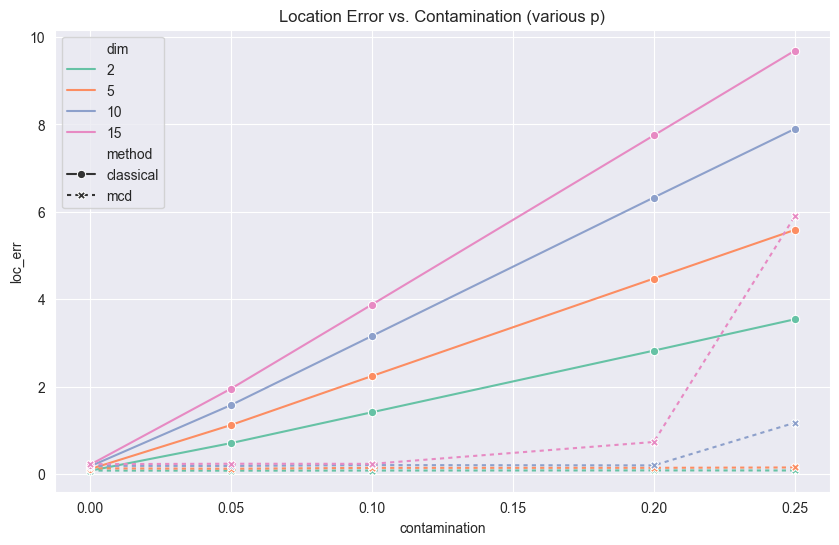

In [14]:

##############################################################################
# 5. Visualization / Example Usage
##############################################################################

if __name__ == '__main__':
    # 1) Run the simulation
    df_results = run_simulation(
        p_values=[2, 5, 10, 15],
        n=300,
        contamination_levels=[0.0, 0.05, 0.1, 0.2, 0.25],
        n_sims=100
    )
    
    # 2) Summarize
    print(df_results)
    
    # 3) Approximate efficiency: compare MCD vs. classical at alpha=0.1 (example)
    df_eff_mcd = compute_efficiency(df_results, method='mcd', reference='classical', alpha=0.1)
    print(df_eff_mcd)
    
    # 4) Plot loc_err vs. contamination
    #    Each dimension has its own color; methods differ by line style
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=df_results,
        x='contamination',
        y='loc_err',
        hue='dim',                # same color for each dimension
        style='method',           # different style for classical vs. mcd
        dashes={'classical': '',  # '' => solid line
                'mcd': (2, 2)},   # (2, 2) => dotted line
        palette='Set2',
        markers=True,             # use markers
        ci=None
    )


    plt.legend()

    plt.title('Location Error vs. Contamination (various p)')
    plt.show()

    # Similarly, you can plot cov_err or create boxplots, etc.



In [16]:
import pandas as pd

def make_robustness_table(df):
    """
    Create a pivot table comparing classical vs. mcd 
    in terms of location error for each dimension and contamination level.
    Returns a DataFrame suitable for display.
    """

    # 1. Group by (dim, contamination, method) and compute the MEAN loc_err
    grouped = df.groupby(['dim','contamination','method'])['loc_err'].mean()

    # 2. 'Unstack' the 'method' level so classical and mcd become separate columns
    pivoted = grouped.unstack('method')

    # Optionally rename columns for clarity
    pivoted = pivoted.rename(columns={
        'classical': 'Classical (Mean Loc. Err)',
        'mcd': 'MCD (Mean Loc. Err)'
    })
    
    # pivoted will have a MultiIndex of (dim, contamination).
    # If you prefer a flat index, you can reset the index:
    pivoted = pivoted.reset_index()
    
    # Then reorder columns in a nice order
    pivoted = pivoted[['dim','contamination','Classical (Mean Loc. Err)','MCD (Mean Loc. Err)']]
    
    return pivoted

# Example usage:
df_robust = make_robustness_table(df_results)
print(df_robust.to_string(index=False))


 dim  contamination  Classical (Mean Loc. Err)  MCD (Mean Loc. Err)
   2           0.00                   0.064799             0.069314
   2           0.05                   0.714762             0.062914
   2           0.10                   1.413483             0.059344
   2           0.20                   2.826240             0.066997
   2           0.30                   4.242486             0.067125
   5           0.00                   0.092599             0.097836
   5           0.05                   1.121549             0.102773
   5           0.10                   2.235310             0.108510
   5           0.20                   4.469613             0.110600
   5           0.30                   6.710229             0.441493
  10           0.00                   0.135626             0.144154
  10           0.05                   1.589145             0.149804
  10           0.10                   3.166200             0.157271
  10           0.20                   6.323298  

In [17]:
df_robust.style.format("{:.4f}")

method,dim,contamination,Classical (Mean Loc. Err),MCD (Mean Loc. Err)
0,2.0000,0.0000,0.0648,0.0693
1,2.0000,0.0500,0.7148,0.0629
2,2.0000,0.1000,1.4135,0.0593
3,2.0000,0.2000,2.8262,0.0670
4,2.0000,0.3000,4.2425,0.0671
5,5.0000,0.0000,0.0926,0.0978
6,5.0000,0.0500,1.1215,0.1028
7,5.0000,0.1000,2.2353,0.1085
8,5.0000,0.2000,4.4696,0.1106
9,5.0000,0.3000,6.7102,0.4415


In [19]:
import pandas as pd

def make_pivot_table(df, method='mcd'):
    """
    Produces a pivot table that shows, for each dimension (dim),
    the average loc_err of the given method, with separate columns 
    for each contamination level.

    df: DataFrame with columns: dim, contamination, method, loc_err, ...
    method: the method to filter on (e.g. 'mcd' or 'classical').

    Returns a pivoted DataFrame where columns are the contamination levels.
    """

    # 1) Filter the DataFrame to only the chosen method
    df_filt = df[df['method'] == method]

    # 2) Group by (dim, contamination) and compute the average loc_err
    df_grouped = df_filt.groupby(['dim', 'contamination'], as_index=False)['loc_err'].mean()

    # 3) Pivot so contamination becomes separate columns
    df_pivot = df_grouped.pivot(
        index='dim', 
        columns='contamination', 
        values='loc_err'
    )

    # 4) OPTIONAL: Rename contamination columns from 0.05 -> '5%', etc.
    #    We'll convert them to strings and multiply by 100
    #    Then add a '%' sign
    new_cols = {c: f"{int(c*100)}%" for c in df_pivot.columns}
    # For example, 0.0 -> '0%', 0.05 -> '5%', 0.1 -> '10%', etc.
    df_pivot = df_pivot.rename(columns=new_cols)

    # 5) OPTIONAL: reorder columns in ascending order of contamination
    #    If you'd like a specific order, you can do something like:
    # col_order = ['0%', '5%', '10%', '20%', '30%']
    # df_pivot = df_pivot[col_order]

    return df_pivot

# Example usage:
df_mcd_pivot = make_pivot_table(df_results, method='mcd')
print(df_mcd_pivot)


contamination        0%        5%       10%       20%        30%
dim                                                             
2              0.069314  0.062914  0.059344  0.066997   0.067125
5              0.097836  0.102773  0.108510  0.110600   0.441493
10             0.144154  0.149804  0.157271  0.159526   8.303446
15             0.184021  0.182065  0.184316  0.337595  11.170106


In [20]:
df_classical_pivot = make_pivot_table(df_results, method='classical')
print(df_classical_pivot)

contamination        0%        5%       10%       20%        30%
dim                                                             
2              0.064799  0.714762  1.413483  2.826240   4.242486
5              0.092599  1.121549  2.235310  4.469613   6.710229
10             0.135626  1.589145  3.166200  6.323298   9.483598
15             0.173599  1.947208  3.877840  7.745825  11.623774


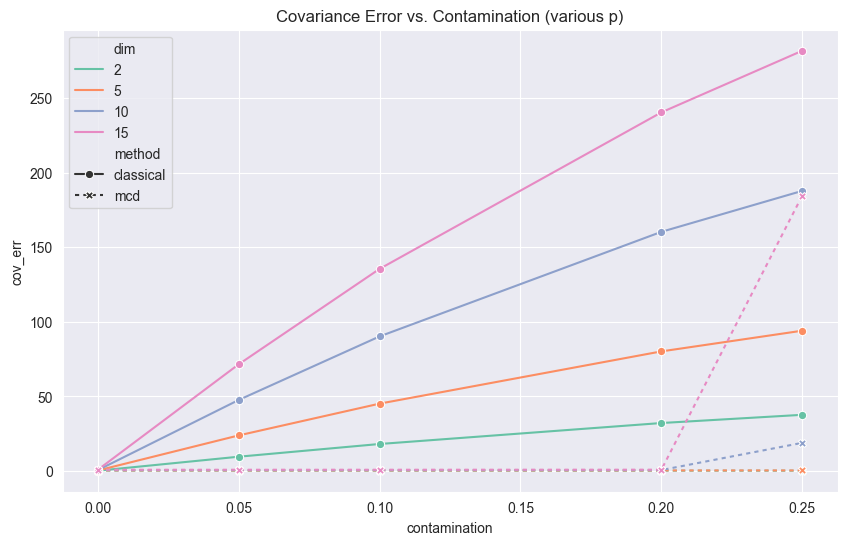

In [32]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=df_results,
    x='contamination',
    y='cov_err',        # <- changed to 'cov_err'
    hue='dim',
    style='method',
    dashes={'classical': '', 'mcd': (2,2)},
    palette='Set2',     # or whichever palette you prefer
    markers=True,
    errorbar=None
)
plt.title('Covariance Error vs. Contamination (various p)')
plt.show()


